In [ ]:
!pip install openreview-py

import openreview
import pandas as pd

[]

In [ ]:
# Fill in or change as needed
username = "" #your OpenReview email
password = ""
venue_id = 'ACM.org/TheWebConf/2024/Conference'  # Replace with the actual conference ID
list_score_field = ["scope", "novelty", "technical_quality", "reviewer_confidence"] # Score fields can be different field for each conference)

In [ ]:
def get_reviews(venue_id):
    venue_group = client.get_group(venue_id)
    submission_name = venue_group.content['submission_name']['value']
    submissions = client.get_all_notes(invitation=f'{venue_id}/-/{submission_name}', details='replies')

    review_name = venue_group.content['review_name']['value']

    reviews=[openreview.api.Note.from_json(reply) for s in submissions for reply in s.details['replies'] if f'{venue_id}/{submission_name}{s.number}/-/{review_name}' in reply['invitations']]
    return reviews

In [ ]:
def get_scores(reviews):
    result = {}
    for review in reviews:

        rev_id = review.id
        forum = review.forum

        if forum not in result:
            result[forum] = {}

        # Access rating details as needed, e.g., (can be different field for each conference)
        scope = review.content["scope"]["value"][0] #index [0] as the scores are single-digit, adjust accordingly
        novelty = review.content["novelty"]["value"][0]
        tq = review.content["technical_quality"]["value"][0]
        conf = review.content["reviewer_confidence"]["value"][0]

        result[forum][rev_id] = dict(scope=scope, novelty=novelty, technical_quality=tq, reviewer_confidence=conf)
    return result

In [ ]:
def aggregate_result_per_paper(result):
    agg_result = {}
    for forum in result:
        tes = pd.DataFrame(result[forum])
        res = tes.T.map(int).describe().to_dict()
        agg_result[forum] = res

    return agg_result

In [ ]:
# API V2
client = openreview.api.OpenReviewClient(
    baseurl='https://api2.openreview.net',
    username=username,
    password=password
)

In [ ]:
reviews = get_reviews(venue_id)
result = get_scores(reviews)
agg_result = aggregate_result_per_paper(result)
final_df = pd.DataFrame(agg_result).T

In [ ]:
#get the range of mean scores per paper, for each aspect/field
for aspect in list_score_field:
    min_val = final_df[aspect].apply(lambda x: x["mean"]).min()
    max_val = final_df[aspect].apply(lambda x: x["mean"]).max()
    print(f"Average {aspect} per paper: {min_val}--{max_val}")

Average scope per paper: 2.2--4.0
Average novelty per paper: 3.2--6.333333333333333
Average technical_quality per paper: 3.6--6.75
Average reviewer_confidence per paper: 1.75--4.0


array([[<Axes: title={'center': 'scope'}>,
        <Axes: title={'center': 'novelty'}>],
       [<Axes: title={'center': 'technical_quality'}>,
        <Axes: title={'center': 'reviewer_confidence'}>]], dtype=object)

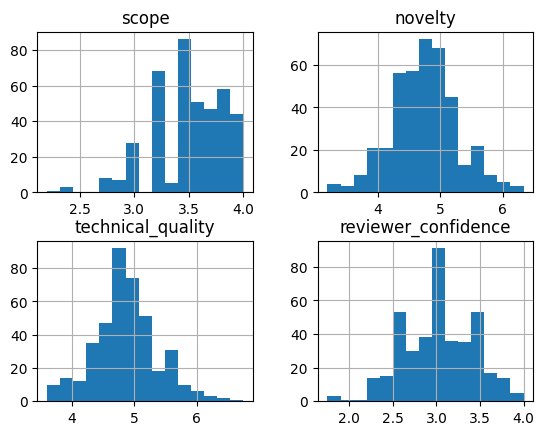

In [ ]:
#plot histogram
final_df.map(lambda x: x["mean"]).hist(bins=15)